In [1]:
import torch
import models.pointnet2_classification as ptnet
from models.cirtorch_network import init_network, extract_vectors
import torch_geometric
from torch_geometric.data import Data
from models.cirtorch_utils.genericdataset import PointCloudImagesFromList, PCDataLoader
from dataset_loaders.txt_to_db import get_images, get_points
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from torch_geometric.data import DataLoader

#%load_ext autoreload
#%autoreload 2

In [6]:
from dataset_loaders.cambridge import Cambridge
cambridge_dataset = Cambridge(demean=False)

(1577, 3)
[4.327126  2.6167076 4.9211836]
[4.918782  5.2081857 1.7338169]
0.39813396


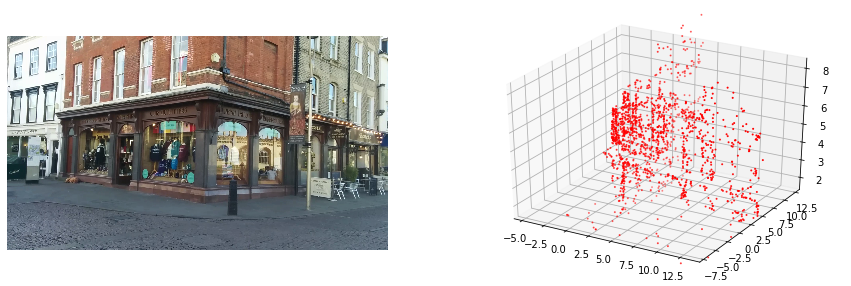

In [7]:
example_img_id = 0
img, pts, _, _ = cambridge_dataset[example_img_id]
example_pts = pts.numpy()
print(example_pts.shape)
mid, std = example_pts.mean(axis=0), example_pts.std(axis=0)
print(mid)
print(std)
print(np.std(std)/np.mean(std))
rng = 2*std
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(121)
ax.imshow(img)
#xys = np.vstack(imgs[example_img_id].xys)
#print(xys.shape)
#ax.scatter(xys[:,0] + img.shape[1]//2, xys[:,1] + img.shape[0]//2, s=1.0, c='r', marker='x')
ax.axis('off')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(example_pts[:,0], example_pts[:,1], example_pts[:,2], color='r', s=1.0)
ax.set_xlim3d(mid[0]-rng[0], mid[0]+rng[0])
ax.set_ylim3d(mid[1]-rng[1], mid[1]+rng[1])
ax.set_zlim3d(mid[2]-rng[2], mid[2]+rng[2])
#fig.savefig('figures/ShopFacadePoints_{}.png'.format(example_img_id), bbox_inches="tight")
plt.show()

In [ ]:
pointnet = ptnet.NetAachen()

In [ ]:
test_sample = Data(pos=torch.Tensor(10, 3), batch=torch.LongTensor([0]*10))

In [ ]:
test_result = pointnet(test_sample)

In [ ]:
print(test_result.size())

In [ ]:
#params = {'mean', [], 'std': []}
cir = init_network({'architecture' : 'resnet34'})

In [ ]:
fd = cir(torch.Tensor(1, 3, 256, 256))

In [ ]:
print(fd.size())

In [2]:
if not 'images' in locals():
    images = get_images()
if not 'points3d' in locals():
    points3d = get_points()
print('Done')

Done


In [ ]:
# set up the transform
normalize = transforms.Normalize(
   mean=cir.meta['mean'],
   std=cir.meta['std']
)
transform = transforms.Compose([
    transforms.CenterCrop(1024),
    transforms.ToTensor(),
    normalize
])

In [84]:
transform = transforms.Compose([
    transforms.Resize(1024),
    transforms.CenterCrop(1024), 
])
sampler = PointCloudImagesFromList('data/AachenDayNight/images_upright', images, points3d, 
                                   imsize=1024, transform=transform, triplet=True, 
                                   min_num_points=500, max_std_std=0.25, within_std=1.0,
                                   deterministic=False, demean=False
                                  )
print('{} items in dataset'.format(len(sampler)))

1078 items in dataset


In [ ]:
overfit = 5
dataloader = PCDataLoader(sampler, batch_size=cp['Training'].getint('batch_size', 10) if overfit < 0 else 1, shuffle=True if overfit < 0 else False)
val_loader = PCDataLoader(sampler, batch_size=1, shuffle=False)

In [ ]:
for i, (d, v) in enumerate(zip(dataloader, val_loader)):
    t1 = d
    t2 = v
    print(torch.nn.functional.mse_loss(t1[0], t2[0]))
    if i > min(overfit, len(dataloader)):
        break

In [ ]:
cir.train()
n1 = cir(t1[0])
cir = cir.eval()
n2 = cir(t1[0])
#print(n1)
#print(n2)
#torch.nn.functional.mse_loss(n1, n2)
#print(n1-n2)

In [ ]:
for i, d in enumerate(dl):
    print(i)
    print(d[0].size())
    print(d[1])
    print(d[2].size())
    print(d[3])
    break
t1 = cir(d[0])
t2 = pointnet(d[1])
print(t1.size())
print(t2.size())

In [120]:
test_id = 16
test_img, test_pts, triplet_img, triplet_pts = sampler[test_id]

[955.5919    -9.170663 148.87416 ]
[3.7087562 3.090607  4.694705 ]
0.17241505


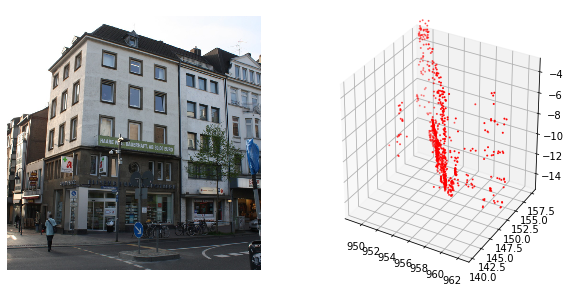

In [121]:
tp = test_pts.numpy()
mid, std = tp.mean(axis=0), tp.std(axis=0)
print(mid)
print(std)
print(np.std(std)/np.mean(std))
rng = 2*std
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.imshow(test_img)
ax.axis('off')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(tp[:,0], tp[:,2], tp[:,1], color='r', s=1.0)
ax.set_xlim3d(mid[0]-rng[0], mid[0]+rng[0])
ax.set_zlim3d(mid[1]-rng[1], mid[1]+rng[1])
ax.set_ylim3d(mid[2]-rng[2], mid[2]+rng[2])
#fig.savefig('figures/good_img_pc_correspondence_{}.png'.format(test_id), bbox_inches="tight")
plt.show()

[-4.4347281e-08  3.9479172e-08 -5.6992491e-09]
[0.99999976 0.99999964 0.9999996 ]
8.4293724e-08


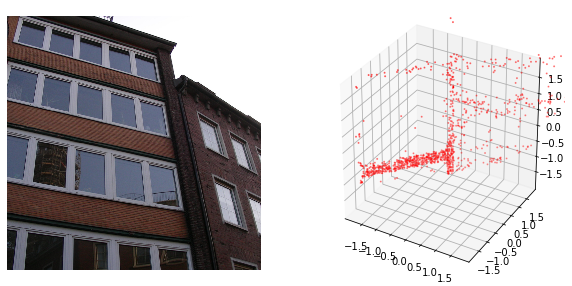

In [25]:
tp = triplet_pts.numpy()
mid, std = tp.mean(axis=0), tp.std(axis=0)
print(mid)
print(std)
print(np.std(std)/np.mean(std))
rng = 2*std
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.imshow(triplet_img)
ax.axis('off')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(tp[:,0], tp[:,2], tp[:,1], color='r', s=1.0)
ax.set_xlim3d(mid[0]-rng[0], mid[0]+rng[0])
ax.set_zlim3d(mid[1]-rng[1], mid[1]+rng[1])
ax.set_ylim3d(mid[2]-rng[2], mid[2]+rng[2])
#fig.savefig('figures/img_pc_correspondence_{}.png'.format(test_id), bbox_inches="tight")
plt.show()

In [ ]:
print(test_pts.size())

In [ ]:
plt.imshow(test_img.transpose(0, -1).transpose(0,1).numpy()*cir.meta['std']+cir.meta['mean'])
plt.axis('off')
plt.show()

In [ ]:
tp = test_pts.numpy()
tt = test_triplet.numpy()
tpt = np.concatenate([tp, tt])
mid, rng = tpt.mean(axis=0), 2*tpt.std(axis=0)
print(mid)
print(rng)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tp[:,0], tp[:,2], tp[:,1], color='r')
ax.scatter(tt[:,0], tt[:,2], tt[:,1], color='g')
ax.set_xlim3d(mid[0]-rng[0], mid[0]+rng[0])
ax.set_zlim3d(mid[1]-rng[1], mid[1]+rng[1])
ax.set_ylim3d(mid[2]-rng[2], mid[2]+rng[2])
plt.show()

In [ ]:
image_ids = {i : k for i, k in enumerate(images.keys())}

In [ ]:
plt.imshow(plt.imread('data/AachenDayNight/images_upright/'+images[image_ids[test_id]].name))
plt.show()

In [ ]:
pt_ids = images[image_ids[test_id]].point3D_ids[images[image_ids[test_id]].point3D_ids > 0]
pts = torch.stack([torch.from_numpy(points3d[i].xyz) for i in pt_ids]).numpy()
print(np.linalg.norm(pts - test_pts.numpy()))

In [ ]:
import random

In [ ]:
random.seed(0)

In [ ]:
random.choice(image_ids)

In [ ]:
i = 0
while True:
    trp_idx = random.choice(image_ids)
    print(trp_idx)
    valid_trp = images[trp_idx].point3D_ids > 0
    pt_ids_trp = images[trp_idx].point3D_ids[valid_trp]
    shared = np.intersect1d(pt_ids, pt_ids_trp, assume_unique=True)
    print(shared.shape)
    print(pt_ids.shape[0]*0.01)
    if shared.shape[0] < pt_ids.shape[0] * 0.01:
        break
    i += 1
print(i)

In [ ]:
data_to_ptnet = lambda x: Data(pos=x.float(), batch=torch.LongTensor([0]*x.size(0)))

In [ ]:
x = pointnet(data_to_ptnet(test_pts))
y = pointnet(data_to_ptnet(test_triplet))
z = cir(test_img.unsqueeze(0))

In [ ]:
print(x.size())
print(y.size())
print(z.size())

In [ ]:
for i, x in enumerate(sampler):
    if (i % 1000) == 0:
        print(i)
print(i)